In [191]:
%matplotlib inline

In [192]:
import numpy as np
import pandas as pd
import pickle as pkl
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
from matplotlib import pyplot as plt
from datetime import timedelta
from joblib import delayed, Parallel
from copy import copy

from core import  do_simulation
from helpers import Params, T, get_T1_and_T2, R0, plot_total, save_bundle, save_to_json

from const import STATE, COLORS, NUM_STATES,  STATES


In [193]:
tran_coef_before = np.array([4.28, 5.28, 5.33, 4.38, 4.13, 5.27, 5.28, 5.32, 5.15, 5.22, 4.46, 4.20, 5.17, 5.11, 4.91, 4.92, 4.87, 4.04, 4.32, 4.22 , 3.60, 2.88])
tran_coef_after = np.array([0.66 ,0.67 ,0.68 ,0.66 ,0.69 ,0.69 ,0.66 ,0.69 ,0.68 ,0.67 ,0.60 ,0.62 ,0.61 ,0.62 ,0.62 ,0.61 ,0.60 ,0.62 ,0.67 ,0.60 ,0.58 ,0.59 ,0.58 ,0.57 ,0.59 ,0.60 ,0.57 ])
infection_factor = np.mean(tran_coef_before) / np.mean(tran_coef_after)
infection_factor = np.log(infection_factor)
infection_factor

1.999881671966743

In [194]:
params_jan27 = pkl.load(
    open('output/params_after_lockdown.pkl', 'rb')
)

In [195]:
params_jan27

total_population: 9000000
initial_num_E: 5000.0
initial_num_I: 5000
initial_num_M: 4000.0

alpha: 1.5999999999999998e-08
beta:  1.7e-09

mu_ei: 6

x0_pt: 3000
k_pt:  0.0005972530000000001

mu_mo: 10

k_days: 14
        

In [196]:
lockdown_date = T('23/01/2020')
lockdown_date

datetime.datetime(2020, 1, 23, 0, 0)

In [197]:
target_E = params_jan27.initial_num_E
target_I = params_jan27.initial_num_I
target_M = params_jan27.initial_num_M

actual_I = np.array([target_I])
actual_E = np.array([target_E])
actual_M = np.array([target_M])

actual_E, actual_I, actual_M

(array([5000.]), array([5000]), array([4000.]))

In [218]:
def prepare_params(t):
    p = Params(
        alpha=[(0, infection_factor * params_jan27.alpha), (t, params_jan27.alpha)],
        beta=[(0, infection_factor * params_jan27.beta), (t, params_jan27.beta)],
        stages=[t],
        initial_num_E=1,
        initial_num_I=0,
        initial_num_M=0,
        mu_ei=params.mu_ei,
        mu_mo=params.mu_mo,
        x0_pt=params.x0_pt,
        k_days=params.k_days
    )
    return p
        

In [219]:
bed_info = [(0, 3000)]
def one_run(t):
    params = prepare_params(t)
    # t days **before** lockdown (Jan 23)
    # simulation finishes at Jan 27 (after lockdown for 5 days)
    # t=1, 2, 3, ... means patient zero  appeared in Jan 22, 21, 20
    p0_time = lockdown_date - timedelta(days=t)
    
    total, _, _, _, stats = do_simulation(
        t+5, bed_info, params, p0_time=p0_time,
        verbose=0
    )
    
    pred_I = np.array([total[-1, STATE.I]])
    pred_E = np.array([total[-1, STATE.E]])
    pred_M = np.array([total[-1, STATE.M]])
    
    mse_I = mean_absolute_error(actual_I,  pred_I)
    mse_E = mean_absolute_error(actual_E, pred_E)
    mse_M = mean_absolute_error(actual_M, pred_M)
    mse_IM = mean_absolute_error(actual_M + actual_I, pred_M + pred_I)
    mse_IEM = mean_absolute_error(actual_I + actual_E + actual_M,  pred_I + pred_E + pred_M)
    return (t, actual_I[0], pred_I[0], mse_I, mse_E, mse_M, mse_IM, mse_IEM, stats)

In [220]:
# t is the number of days back
rows = Parallel(n_jobs=-1)(delayed(one_run)(t) for t in tqdm(range(30, 61)))

100%|██████████| 31/31 [00:03<00:00,  8.26it/s]


In [221]:
df = pd.DataFrame(rows, columns=('t', 'actual_I', 'pred_I', 'mse_I', 'mse_E', 'mse_M', 'mse_IM', 'mse_IEM', 'r0_info'))

In [222]:
df.sort_values(by='mse_I').head(10)

,t,actual_I,pred_I,mse_I,mse_E,mse_M,mse_IM,mse_IEM,r0_info
24,54,5000,4637.226933,362.773067,1168.653543,1207.397048,1570.170115,401.516572,"{'R0_by_stage': {0: (5.143549311625715, 1.9865..."
25,55,5000,5756.684184,756.684184,2269.108273,1000.000000,243.315816,2025.792458,"{'R0_by_stage': {0: (5.1431327211747755, 2.024..."
23,53,5000,3308.540110,1691.459890,242.781725,1000.000000,2691.459890,2448.678165,"{'R0_by_stage': {0: (5.143896124718022, 1.9530..."
22,52,5000,2625.064383,2374.935617,541.578061,1265.197241,3640.132857,4181.710918,"{'R0_by_stage': {0: (5.1441820266815945, 1.923..."
26,56,5000,7591.373888,2591.373888,3569.379666,1261.918673,1329.455215,4898.834881,"{'R0_by_stage': {0: (5.142636306099425, 2.0674..."
21,51,5000,2106.000291,2893.999709,1207.071899,1549.569099,4443.568808,5650.640707,"{'R0_by_stage': {0: (5.14441462515235, 1.89821..."
20,50,5000,1694.251082,3305.748918,1772.047534,1818.889331,5124.638249,6896.685783,"{'R0_by_stage': {0: (5.144600281428023, 1.8761..."
19,49,5000,1367.940588,3632.059412,2251.963177,2070.412276,5702.471688,7954.434865,"{'R0_by_stage': {0: (5.144744171961296, 1.8570..."
18,48,5000,1109.155814,3890.844186,2659.845973,2302.248978,6193.093163,8852.939136,"{'R0_by_stage': {0: (5.144850370406545, 1.8405..."
17,47,5000,903.458083,4096.541917,3006.680440,2513.404983,6609.946899,9616.627339,"{'R0_by_stage': {0: (5.1449219314967864, 1.826..."


In [223]:
best_t = int(df.sort_values(by='mse_IM').iloc[0].t)
p0_time = T('22/01/2020') - timedelta(days=best_t)
print(p0_time)

2019-11-28 00:00:00


In [225]:
df.to_csv('output/tbl/p0-time/error.csv', index=False)

In [226]:
pkl.dump(p0_time, open('output/p0_time.pkl', 'wb'))

In [227]:
params = copy(params_jan27)
params.alpha = infection_factor * params.alpha
params.beta = infection_factor * params.beta
params.initial_num_E = 1
params.initial_num_I = 0
params.initial_num_M = 0

    
total, delta, increase, trans, stats = do_simulation(best_t, bed_info, params, verbose=0,  p0_time=p0_time)

In [228]:
save_bundle([total, delta, increase, trans], p0_time, best_t, 'output/tbl/before-lockdown')
save_to_json(stats, 'output/tbl/before-lockdown/stat.txt')

In [229]:
pkl.dump(
    params,
    open('output/params_before_lockdown.pkl', 'wb')
)

/home/cloud-user/code/covid-19/helpers.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['index'] = df.index
/home/cloud-user/code/covid-19/helpers.py:286: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['value'] = subdf[state].copy()
/home/cloud-user/code/covid-19/helpers.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

['28/11/19' '09/12/19' '20/12/19' '31/12/19' '11/01/20' '22/01/20']


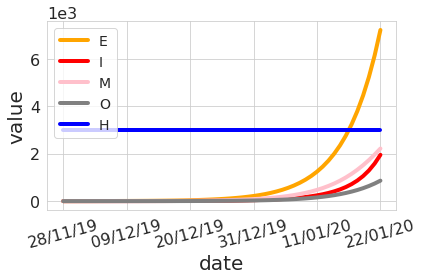

In [230]:
fig, ax = plot_total(total, p0_time, best_t)
fig.savefig('figs/before-lockdown.pdf')